# NeuralProphet

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/ts/blob/main/notebooks/neural_prophet.ipynb)
[![Render nbviewer](https://img.shields.io/badge/render-nbviewer-f37726)](https://nbviewer.org/github/adamelliotfields/ts/blob/main/notebooks/neural_prophet.ipynb)

[NeuralProphet](https://github.com/ourownstory/neural_prophet) (Triebe et al., [2021](https://arxiv.org/abs/2111.15397)) is a successor to Meta's [Prophet](https://research.facebook.com/blog/2017/2/prophet-forecasting-at-scale/) for time series forecasting. It is inspired by AR-Net (Triebe et al., [2019](https://arxiv.org/abs/1911.12436)) and built with PyTorch.

Note that this is a basic demonstration based on the [tutorial](https://neuralprophet.com/quickstart.html), adapted to use the Air Passengers dataset from [Statsmodels](https://github.com/statsmodels/statsmodels). The [`neuralprophet-data`](https://github.com/ourownstory/neuralprophet-data) repo has additional time series datasets to explore.

In [1]:
# @title Imports
import subprocess
import sys
import warnings

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

from datetime import datetime
from importlib.util import find_spec

if not find_spec("neuralprophet"):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "neuralprophet"])

if not find_spec("torchinfo"):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "torchinfo"])

from neuralprophet import NeuralProphet, set_log_level, set_random_seed
from torchinfo import summary

warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option("display.width", 200)

set_random_seed(42)
set_log_level("ERROR")

The [Air Passengers](https://www.rdocumentation.org/packages/datasets/topics/AirPassengers) dataset contains the monthly totals of international air travel passengers between 1949 and 1960.

In [2]:
ds = sm.datasets.get_rdataset("AirPassengers")
df = ds.data
df.head()

,time,value
0,1949.000000,112
1,1949.083333,118
2,1949.166667,132
3,1949.250000,129
4,1949.333333,121


We need to convert the dates from fractional to ISO 8601 format. We also need to rename the columns to `ds` and `y`, which are requirements for NeuralProphet.

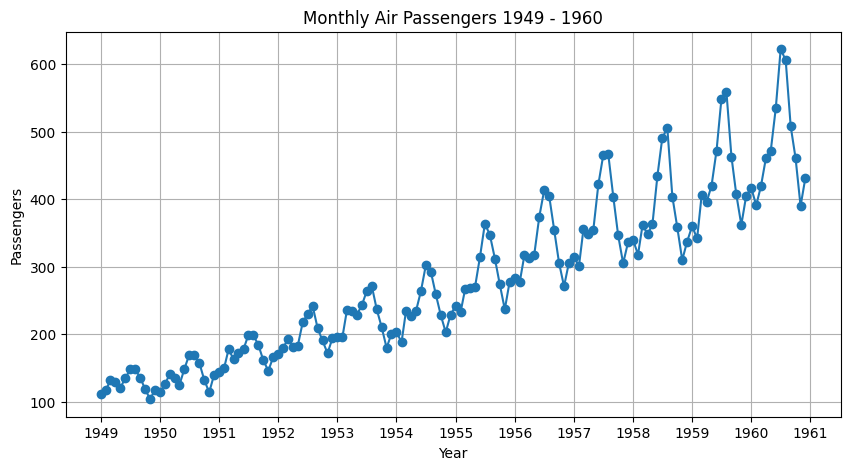

In [3]:
def parse_time(t):
    year = int(t)
    month = t - year
    month = round(month * 12) + 1
    return datetime(year, month, 1)


df["time"] = df["time"].apply(parse_time)
df.columns = ["ds", "y"]

# plot
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["ds"], df["y"], marker="o", linestyle="-")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.title("Monthly Air Passengers 1949 - 1960")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.grid(True)
plt.show()

NeuralProphet fits additive seasonalities by default. This means the seasonal effect is constant. The Air Passengers dataset has multiplicitive seasonality, meaning the seasonal effect is proportional with the level of the series (as more people fly in general, more people will fly in the peak season).

NeuralProphet can actually determine good initial values for learning rate, batch size, and epochs based on the dataset.

In [4]:
# build model
model = NeuralProphet(
    quantiles=[0.05, 0.95],
    seasonality_mode="multiplicative",
)
model.set_plotting_backend("matplotlib")

# 80/20 split (MS means "month start")
train_df, test_df = model.split_df(df, freq="MS", valid_p=0.20)

# train
metrics_train = model.fit(train_df, validation_df=test_df, freq="MS", progress=None)
print(metrics_train.tail())

       MAE_val   RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE      Loss  RegLoss
225  19.424484  23.628471  0.013333          0.0    225  6.420148  7.802782  0.001028      0.0
226  19.424765  23.625690  0.013294          0.0    226  6.642505  8.037528  0.001068      0.0
227  19.422525  23.634645  0.013253          0.0    227  6.252924  7.627749  0.000962      0.0
228  19.348524  23.554216  0.013092          0.0    228  6.405210  7.698803  0.000988      0.0
229  19.227829  23.430540  0.012899          0.0    229  6.359145  7.674790  0.000981      0.0


In [5]:
# eval
metrics_test = model.test(test_df)
print(metrics_test)

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.012898837216198444
         MAE_val            19.227828979492188
        RMSE_val            23.430540084838867
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     MAE_val  RMSE_val  Loss_test  RegLoss_test
0  19.227829  23.43054   0.012899           0.0


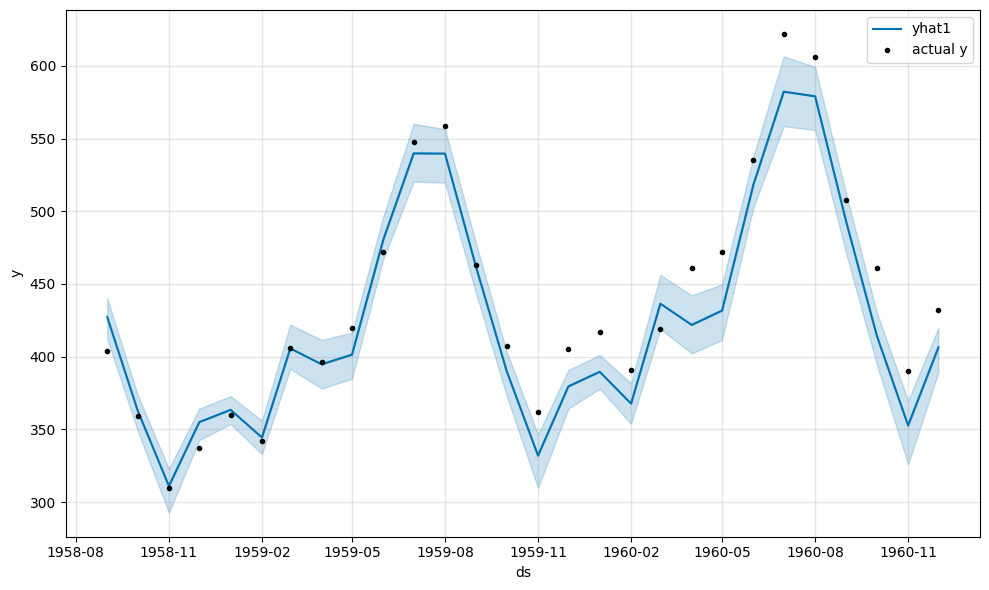

In [6]:
forecast = model.predict(test_df)
model.plot(forecast)

Before predicting the future, refit the model using the entire dataset now that we know the model is pretty good at capturing the patterns in the data.

In [7]:
model = NeuralProphet(
    quantiles=[0.05, 0.95],
    seasonality_mode="multiplicative",
)
model.set_plotting_backend("matplotlib")
model.fit(df, freq="MS", progress=None)

,MAE,RMSE,Loss,RegLoss,epoch
0,364.027161,408.364746,2.333721,0.0,0
1,332.383667,372.199036,2.132495,0.0,1
2,301.166199,342.496674,1.937114,0.0,2
3,269.819702,308.292847,1.738741,0.0,3
4,236.273895,272.950378,1.534753,0.0,4
...,...,...,...,...,...
215,7.888861,9.862016,0.001167,0.0,215
216,7.886148,9.749473,0.001166,0.0,216
217,7.885908,9.879357,0.001166,0.0,217
218,7.885483,9.777248,0.001166,0.0,218


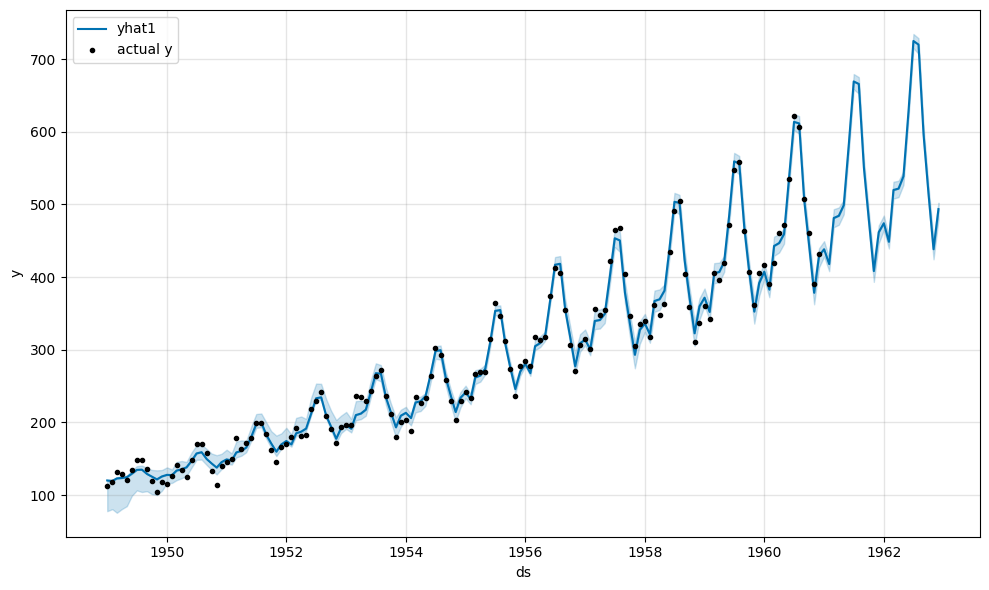

In [8]:
future_df = model.make_future_dataframe(df, periods=24, n_historic_predictions=len(df))
forecast = model.predict(future_df)
model.plot(forecast)

We can view the model's components.

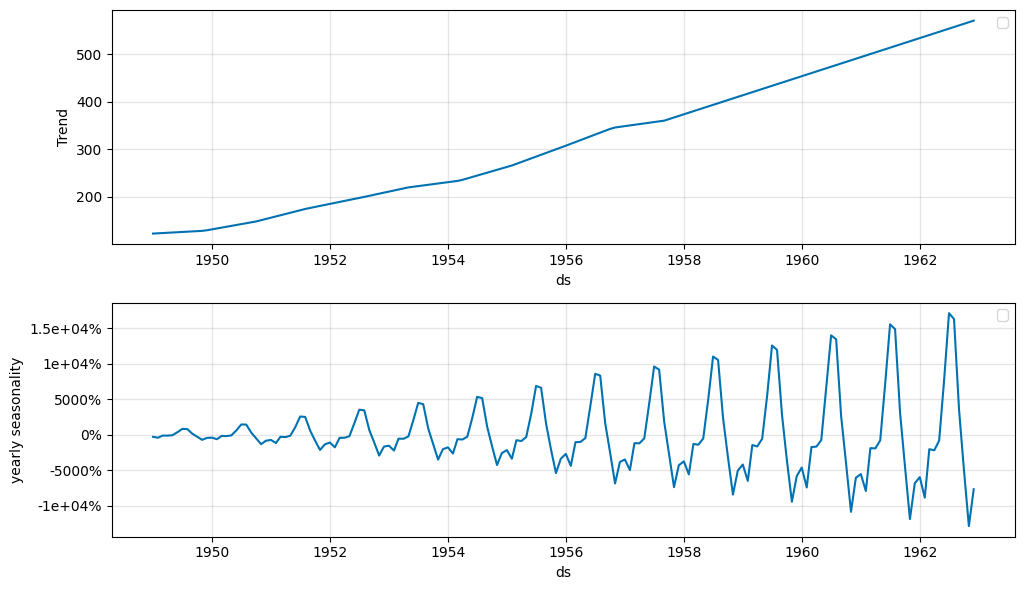

In [9]:
model.plot_components(forecast)

We can view the model's parameters.

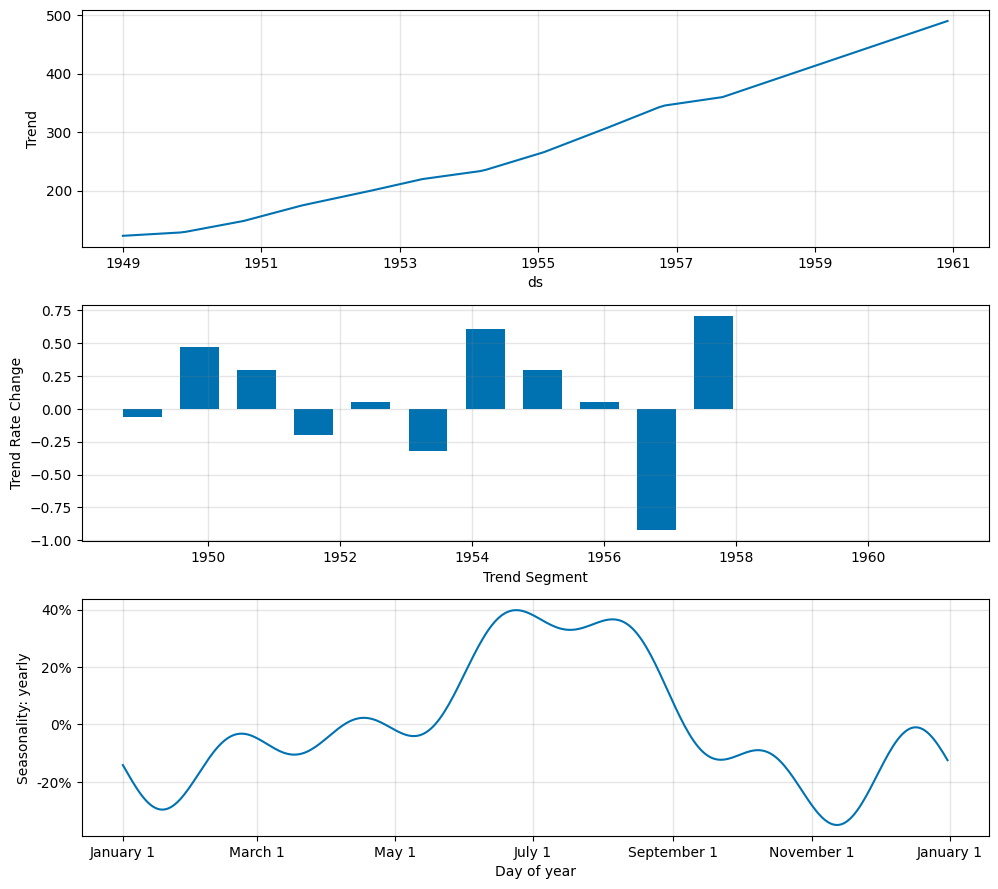

In [10]:
model.plot_parameters()

Finally, we can print the [torchinfo](https://github.com/TylerYep/torchinfo) summary.

In [11]:
summary(model.model)

Layer (type:depth-idx)                   Param #
TimeNet                                  --
├─MetricCollection: 1-1                  --
│    └─MeanAbsoluteError: 2-1            --
│    └─MeanSquaredError: 2-2             --
├─MetricCollection: 1-2                  --
│    └─MeanAbsoluteError: 2-3            --
│    └─MeanSquaredError: 2-4             --
├─GlobalPiecewiseLinearTrend: 1-3        39
├─GlobalFourierSeasonality: 1-4          --
│    └─ParameterDict: 2-5                36
Total params: 75
Trainable params: 75
Non-trainable params: 0